In [1]:
import sys; import numpy as np; from collections.abc import Iterable

# Input data format
from calculations_file_format_single_event import return_result_dtype, Qn_species, Qn_diff_pT_cuts

result_dtype = return_result_dtype('ALICE')
data = np.fromfile('../../../../../2159949.results.dat', dtype=result_dtype)


# Examining the input
nev = len(data['ALICE'][:,0]['dNch_deta']) 
print(nev)
#for i in range(4835): print (data['ALICE'][:,0]['dNch_deta'][i])

Using idf = 0 : Grad
SystemsInfo = 
{'Pb-Pb-2760': {'proj': 'Pb', 'targ': 'Pb', 'sqrts': 2760, 'run_id': 'production_500pts_Pb_Pb_2760', 'n_design': 500, 'n_validation': 100, 'design_remove_idx': [289, 483, 324, 326, 459, 429, 334, 462, 242, 341, 406, 440, 377, 123, 447], 'npc': 10, 'MAP_obs_file': 'main.dat'}}
4835


In [2]:
# Define the bin edges and centers
pT_bins = Qn_diff_pT_cuts
mid_pT_bins=[(pT_bins[i]+pT_bins[i+1])/2. for i in range(0,len(pT_bins)-1)]
#print((mid_pT_bins))

# Pick out the pT-differential Qn array
Qn_diff=data['d_flow_pid']

# Pick out the pid tuples
Qn_species_no_Ch=[tmp for tmp in Qn_species if tmp[0] != "Ch"]

In [3]:
# Define jacobian function
def integrated_jacobian(m, pT, etaCut):

    m2=m*m
    pT2=pT*pT
    cosh2EtaCut=np.cosh(2*etaCut)
    sinhEtaCut=np.sinh(etaCut)

    return np.log((np.sqrt(2*m2 + pT2 + pT2*cosh2EtaCut) + np.sqrt(2)*pT*sinhEtaCut)/(np.sqrt(2*m2 + pT2 + pT2*cosh2EtaCut) - np.sqrt(2)*pT*sinhEtaCut))

masses={
'pion':0.138,
'kaon':0.494,
'proton':0.938,
'Sigma':1.189,
'Xi':1.318
}

In [4]:
# Set kinematic cuts
pTminCut = .2
pTmaxCut = 3
etaCut = .8
Qn_rap_range = 2

In [5]:
# read in the pT-differential data
# Create and fill arrays with Qn values in each pT bin

# N_diff is the number of particles, Q2-4_diff are the pT-differential Q-vectors
N_diff = np.zeros(nev); Q2_diff = np.zeros(nev, dtype=complex); Q3_diff = np.zeros(nev, dtype=complex); Q4_diff = np.zeros(nev, dtype=complex); 

# pt1-2_diff are the first and second pT moments using best approximation formula from the differential data
pt1_diff = np.zeros(nev); pt2_diff = np.zeros(nev);

for k in range(nev): # looping over events
    Qn_ch = np.zeros(1,dtype=[('N', '<f8', 4), ('Qn', '<c16', (4,5))])
    Q0 = np.zeros(len(mid_pT_bins))
    for species, pid in Qn_species_no_Ch: # looping over charged particles
        weight=1
        if (species== 'Sigma'):
            weight=2

        for i, pT in enumerate(mid_pT_bins): # looping over the pT-differential bins
            if (pT<pTminCut or pT>pTmaxCut):
                continue
            rapidity_to_pseudorapidity_jacobian=integrated_jacobian(masses[species],pT,etaCut)
            rapidity_to_pseudorapidity_jacobian_pt=integrated_jacobian(masses[species],pT,.4)
            n = Qn_diff[species]['N'][k][:,i]/Qn_rap_range*weight*rapidity_to_pseudorapidity_jacobian
            m = Qn_diff[species]['N'][k][:,i]/Qn_rap_range*weight*rapidity_to_pseudorapidity_jacobian_pt
            Q0[i] += m[0] # used for the pT moment calculation
            Qn_ch['N']+=n
            Qn_ch['Qn']+=Qn_diff[species]['Qn'][k][:,i]/Qn_rap_range*weight*rapidity_to_pseudorapidity_jacobian

    
    # calculate the pT moments
    temp = np.array(mid_pT_bins)*Q0
    pt1_diff[k] = np.sum(temp)
    temp2 = (np.array(mid_pT_bins)**2.)*Q0
    pt2_diff[k] = np.sum(temp2)

    # enter final values in 1D arrays
    N_diff[k] = Qn_ch[0][0][0]
    Q2_diff[k] = Qn_ch[0][1][0][1]
    Q3_diff[k] = Qn_ch[0][1][0][2]
    Q4_diff[k] = Qn_ch[0][1][0][3]

In [6]:
# Sort the mean Qn event-arrays by the charged particle multiplicity in descending order
N = np.zeros(nev); Q2 = np.zeros(nev, dtype=complex); Q3 = np.zeros(nev, dtype=complex); Q4 = np.zeros(nev, dtype=complex); 
Nch = np.zeros(nev); meanpt1 = np.zeros(nev); meanpt2 = np.zeros(nev); Npt = np.zeros(nev); Qempty = np.zeros(nev, dtype=complex);


sort = np.array(sorted(range(nev), key = lambda x: data['ALICE'][:,0]['dNch_deta'][x], reverse=True))
for i in range(nev):
    Nch[i] = data['ALICE'][:,0]['dNch_deta'][sort[i]]
    
        # You may use the pre-calculated, integrated Q-vectors and meanpT read directly from the input data 
        # (pT[0.2, 5.0], eta[-0.8, 0.8] for Qn and the corresponding ranges for meanpT)       
#    Q2[i] = data['ALICE']['flow']['Qn'][0:nev, 0, 1][sort[i]]
#    Q3[i] = data['ALICE']['flow']['Qn'][0:nev, 0, 2][sort[i]]
#    Q4[i] = data['ALICE']['flow']['Qn'][0:nev, 0, 3][sort[i]]
#    N[i] = data['ALICE']['flow']['N'][0:nev, 0][sort[i]]
#    meanpt1[i] = data['ALICE'][:,0]['pT_fluct_chg']['sum_pT'][sort[i]]
#    meanpt2[i] = data['ALICE'][:,0]['pT_fluct_chg']['sum_pT2'][sort[i]]
#    Npt[i] = data['ALICE'][:,0]['pT_fluct_chg']['N'][sort[i]]
    
    # --------------------------------------- #
    
        # Or you may use the pT-differential Q-vectors and number of particles calculated above 
        # (comment out one or the other of these blocks or define new arrays)        
    Q2[i] = Q2_diff[sort[i]]
    Q3[i] = Q3_diff[sort[i]]
    Q4[i] = Q4_diff[sort[i]]
    N[i] = N_diff[sort[i]]
    meanpt1[i] = pt1_diff[sort[i]]
    meanpt2[i] = pt2_diff[sort[i]]
    Npt[i] = N_diff[sort[i]]
    
# check the sorted output 
#for i in range(4835): print (i,data['ALICE'][:,0]['dNch_deta'][i],sort[i],Nch[i],N[i],np.imag(Q2[i]))

In [7]:
# Calculate rho_n and jackknife error
    # ALICE centrality bins
cen = np.array([[0,5],[5,10],[10,20],[20,30],[30,40],[40,50],[50,60],[60,70]])
    # event number bin thresholds
index = (cen/100.*nev).astype(int)
    # centrality bin centers
cenM = np.mean(cen, axis=1); nbin = len(cenM)

cn4_ = np.zeros(nbin); cn2_2_ = np.zeros(nbin); covavg  = np.zeros(nbin); meanPT = np.zeros(nbin); var2 = np.zeros(nbin);

for j, (nl,nh) in enumerate(zip(index[:,0], index[:,1])):
    n = Npt[nl:nh]; k = meanpt1[nl:nh];
    meanPT[j] = np.average(k)/np.average(n) # STAR definition: np.average(k/n) 

rho_jack_samples = []

for i, (nl,nh) in enumerate(zip(index[:,0], index[:,1])):
        # adjust definition of qn and q2n accordingly to obtain rho2 or rho3, use Qempty for higher order Qvectors that are not saved
    x = N[nl:nh]; qn = Q2[nl:nh]; q2n = Q4[nl:nh]; z1 = meanpt1[nl:nh]; z2 = meanpt2[nl:nh]; zn = Npt[nl:nh]

    meanpt_ev = z1/zn # event mean pT
    w = x*(x-1.)
    cn4 = np.real(np.abs(qn)**4 + np.abs(q2n)**2 - 2.*(q2n*(np.conjugate(qn*qn))) - 2.*(2.*(x-2.)*np.abs(qn)**2) + 2*x*(x-3.)) / (x*(x-1.)*(x-2.)*(x-3.))
    cn2_2 = (np.abs(qn)**2 - x)/w; cn2_4 = (np.abs(q2n)**2 - x)/w
        # calculate covariance
    cov = cn2_2*(meanpt_ev-meanPT[i]) 
        # average over events
    cn4_[i] = np.average(cn4); cn2_2_[i] = np.average(cn2_2); covavg[i] = np.average(cov)
        # calculate ck
    var2[i] = np.average((z1**2 - z2)/(zn*(zn-1))) - np.average(z1/zn)**2 
    
        # jackknife resampling
    rho_jack = []; samples = len(cn4)
    jackknife_samples = []
    for l in range(samples):
        x_err = np.delete(x,[l]); qn_err = np.delete(qn,[l]); q2n_err = np.delete(q2n,[l]);
        meanpt_ev_err = np.delete(meanpt_ev,[l]);
        z1_err = np.delete(z1,[l]); z2_err = np.delete(z2,[l]); zn_err = np.delete(zn,[l])
        
        w_err = x_err*(x_err-1.)
        cn4_err = np.real(np.abs(qn_err)**4 + np.abs(q2n_err)**2 - 2.*(q2n_err*(np.conjugate(qn_err*qn_err))) - 2.*(2.*(x_err-2.)*np.abs(qn_err)**2) + 2*x_err*(x_err-3.)) / (x_err*(x_err-1.)*(x_err-2.)*(x_err-3.))
        cn2_2_err = (np.abs(qn_err)**2 - x_err)/w_err; cn2_4_err = (np.abs(q2n_err)**2 - x_err)/w_err
        cov_j = cn2_2_err*(meanpt_ev_err-meanPT[i])

        var1_j = np.average(cn4_err) - np.average(cn2_2_err)**2
        var2_j = np.average((z1_err**2 - z2_err)/(zn_err*(zn_err-1))) - np.average(z1_err/zn_err)**2 

        rho_jack.append(np.average(cov_j)/(np.sqrt(var1_j)*(np.sqrt(var2_j))))
    rho_jack_samples.append(rho_jack)
    
var1 = cn4_ - cn2_2_**2
    # calculate rho
rho = covavg/(np.sqrt(var1)*np.sqrt(var2))
    # calculate the uncertainty
rho_err = np.zeros(nbin)
for i in range(nbin):
    rho_err[i] = np.sqrt((((len(rho_jack_samples[i])-1)/len(rho_jack_samples[i])))*np.sum((rho_jack_samples[i] - rho[i])**2)) 


In [8]:
#print((rho_err,rho))
#print(rho_jack_samples[0][25]-rho[0])

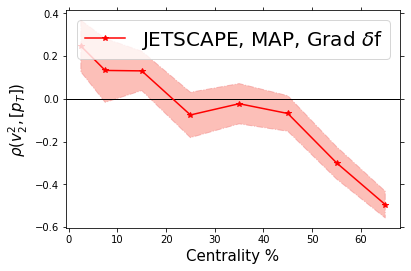

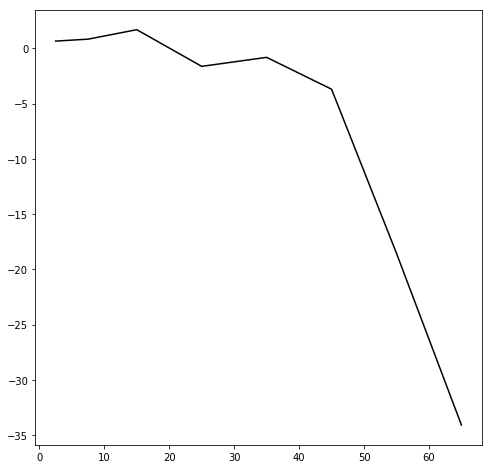

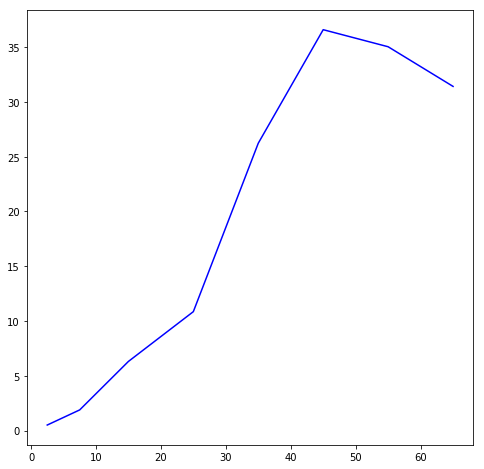

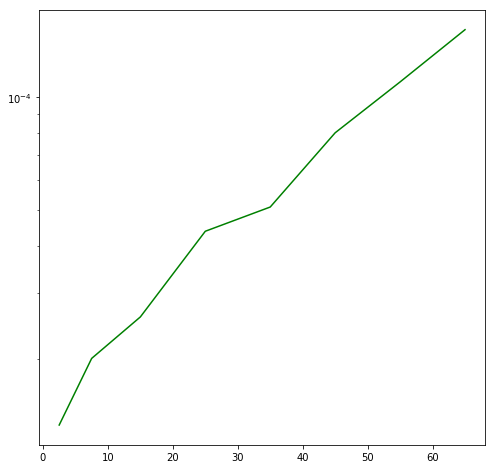

In [10]:
import matplotlib.pyplot as plt

ax = plt.subplot(111)
ax.axhline(linewidth=1, color= 'k')
plt.rcParams["figure.figsize"] = [8, 8]
plt.plot(cenM,rho,'-*r', label = 'JETSCAPE, MAP, Grad $\delta$f') #rho (ALICE pT-Var definition)
ax.fill_between(cenM, rho-rho_err, rho+rho_err,
    alpha=0.5, edgecolor='lightcoral', facecolor='salmon', linestyle='dashdot') #edgecolor='#008000',facecolor='#15B01A'
#ax.set_ylim(ymin=-.55, ymax=.5)
#ax.set_xlim(xmin=0, xmax=80)
plt.xlabel('Centrality %',fontsize=15)
plt.ylabel(r'$\rho (v^{2}_2,[p_T])$',fontsize=15)
ax.yaxis.set_ticks_position('both')
ax.xaxis.set_ticks_position('both')
plt.legend(prop={'size': 20})
plt.savefig('rho.png', bbox_inches='tight', dpi=300)
plt.show()

a = plt.subplot(111)
plt.plot(cenM,covavg*1000000,'k')
plt.show()

a = plt.subplot(111)
plt.plot(cenM,var1*1000000, 'b')
plt.show()

a = plt.subplot(111)
plt.plot(cenM,var2, 'g')
plt.yscale("log")
plt.show()
